In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

First thing I want to do is to check if MPS is available since I am using Apple M2 Chip and would like to use the device GPU

In [9]:
def check_mps_available():
  if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
      print("MPS not available because PyTorch was not built with MPS enabled"
          )
    else:
      print("MPS not available because the current MacOS version is not 12.3+ and /or you do not have an MPS-enabled device")
      
    return False
  return True

def get_device():
  if check_mps_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
  else:
    device = torch.device('cpu')
    print("Using CPU")
  return device
  
device = get_device()

Using MPS (Apple Silicon GPU)


## SimpleNN
A simple neural network model for binary classification.

### Parameters:
- `input_size` (int, default=2): Number of input features
- `hidden_size` (int, default=5): Number of neurons in hidden layer
- `output_size` (int, default=1): Number of output neurons

### Architecture:
1. First Linear Layer: input_size → hidden_size
2. ReLU Activation
3. Second Linear Layer: hidden_size → output_size

### Usage Example:
```python
model = SimpleNN(input_size=2, hidden_size=5, output_size=1)

In [10]:
class SimpleNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=5, output_size=1):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

## Data Preparation

In [33]:
# Create synthetic data
np.random.seed(42)  # For reproducibility
X = np.random.randn(500, 2)  # 500 samples with 2 features each
# Classification rule: sample is positive if sum of features is positive
y = (X[:,0] + X[:,1] > 0).astype(np.float32)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1).to(device)

print(f"Training set: {X_train_tensor.shape[0]} samples")
print(f"Testing set: {X_test_tensor.shape[0]} samples")

Training set: 400 samples
Testing set: 100 samples


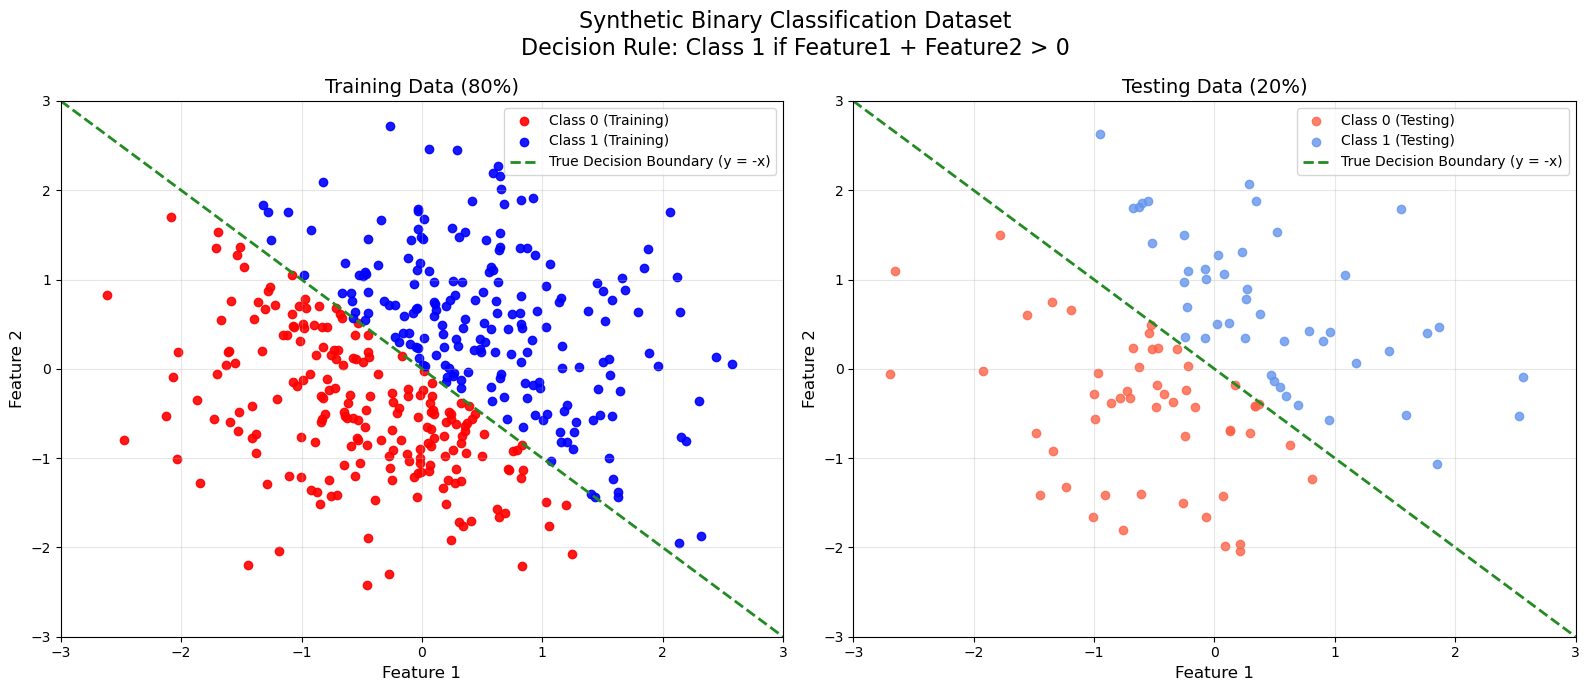

In [34]:
# Create a larger figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Training data
ax1 = axes[0]
ax1.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='red', label='Class 0 (Training)', alpha=0.9)
ax1.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='blue', label='Class 1 (Training)', alpha=0.9)
# True decision boundary x + y = 0, rewritten as y = -x
ax1.axline([0, 0], [1, -1], color='forestgreen', linestyle='--', linewidth=2, label='True Decision Boundary (y = -x)')
ax1.set_xlabel('Feature 1', fontsize=12)
ax1.set_ylabel('Feature 2', fontsize=12)
ax1.set_title('Training Data (80%)', fontsize=14)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([-3, 3])
ax1.set_ylim([-3, 3])

# Plot 2: Testing data
ax2 = axes[1]
ax2.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color='tomato', label='Class 0 (Testing)', alpha=0.8)
ax2.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='cornflowerblue', label='Class 1 (Testing)', alpha=0.8)
# Same decision boundary
ax2.axline([0, 0], [1, -1], color='forestgreen', linestyle='--', linewidth=2, label='True Decision Boundary (y = -x)')
ax2.set_xlabel('Feature 1', fontsize=12)
ax2.set_ylabel('Feature 2', fontsize=12) 
ax2.set_title('Testing Data (20%)', fontsize=14)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([-3, 3])
ax2.set_ylim([-3, 3])

# Overall title
plt.suptitle('Synthetic Binary Classification Dataset\nDecision Rule: Class 1 if Feature1 + Feature2 > 0', 
             fontsize=16, y=0.98)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

## Training Setup

In [35]:
# define the model
model = SimpleNN().to(device)

In [36]:

# Loss function: Measures prediction errors
criterion = nn.BCEWithLogitsLoss()


In [37]:

# Optimizer: Updates network weights
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Training Loop

In [38]:
import time

# Initialize lists to store metrics
train_losses = []
val_losses = []
val_accuracies = []

# Set total epochs and logging frequency
num_epochs = 5000
log_interval = 250
validation_interval = 250

print("Beginning model training...")
start_time = time.time()

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set model to training mode
    outputs = model(X_train_tensor)
    train_loss = criterion(outputs, y_train_tensor)
    
    # Backpropagation and optimization
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    # Store training loss
    train_losses.append(train_loss.item())
    
    # Validation phase (every validation_interval epochs)
    if (epoch + 1) % validation_interval == 0:
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation for inference
            # Compute validation loss
            val_outputs = model(X_test_tensor)
            val_loss = criterion(val_outputs, y_test_tensor)
            val_losses.append(val_loss.item())
            
            # Compute validation accuracy
            predicted = (val_outputs > 0.5).float()
            accuracy = (predicted == y_test_tensor).float().mean().item()
            val_accuracies.append(accuracy)
            
            # Calculate elapsed time
            elapsed_time = time.time() - start_time
            
            print(f'Epoch [{epoch + 1}/{num_epochs}] | '
                  f'Train Loss: {train_loss.item():.4f} | '
                  f'Val Loss: {val_loss.item():.4f} | '
                  f'Val Accuracy: {accuracy*100:.2f}% | '
                  f'Time: {elapsed_time:.2f}s')


Beginning model training...
Epoch [250/5000] | Train Loss: 0.6735 | Val Loss: 0.6738 | Val Accuracy: 53.00% | Time: 0.62s
Epoch [500/5000] | Train Loss: 0.5936 | Val Loss: 0.5863 | Val Accuracy: 56.00% | Time: 0.90s
Epoch [750/5000] | Train Loss: 0.4524 | Val Loss: 0.4384 | Val Accuracy: 78.00% | Time: 1.16s
Epoch [1000/5000] | Train Loss: 0.3145 | Val Loss: 0.2949 | Val Accuracy: 98.00% | Time: 1.43s
Epoch [1250/5000] | Train Loss: 0.2303 | Val Loss: 0.2085 | Val Accuracy: 99.00% | Time: 1.70s
Epoch [1500/5000] | Train Loss: 0.1823 | Val Loss: 0.1602 | Val Accuracy: 99.00% | Time: 1.97s
Epoch [1750/5000] | Train Loss: 0.1529 | Val Loss: 0.1315 | Val Accuracy: 99.00% | Time: 2.24s
Epoch [2000/5000] | Train Loss: 0.1330 | Val Loss: 0.1125 | Val Accuracy: 99.00% | Time: 2.50s
Epoch [2250/5000] | Train Loss: 0.1186 | Val Loss: 0.0992 | Val Accuracy: 99.00% | Time: 2.76s
Epoch [2500/5000] | Train Loss: 0.1075 | Val Loss: 0.0896 | Val Accuracy: 99.00% | Time: 3.02s
Epoch [2750/5000] | Train

## Model Evaluation


Training completed in 11.17 seconds
Final Training Accuracy: 98.25%
Final Testing Accuracy: 100.00%


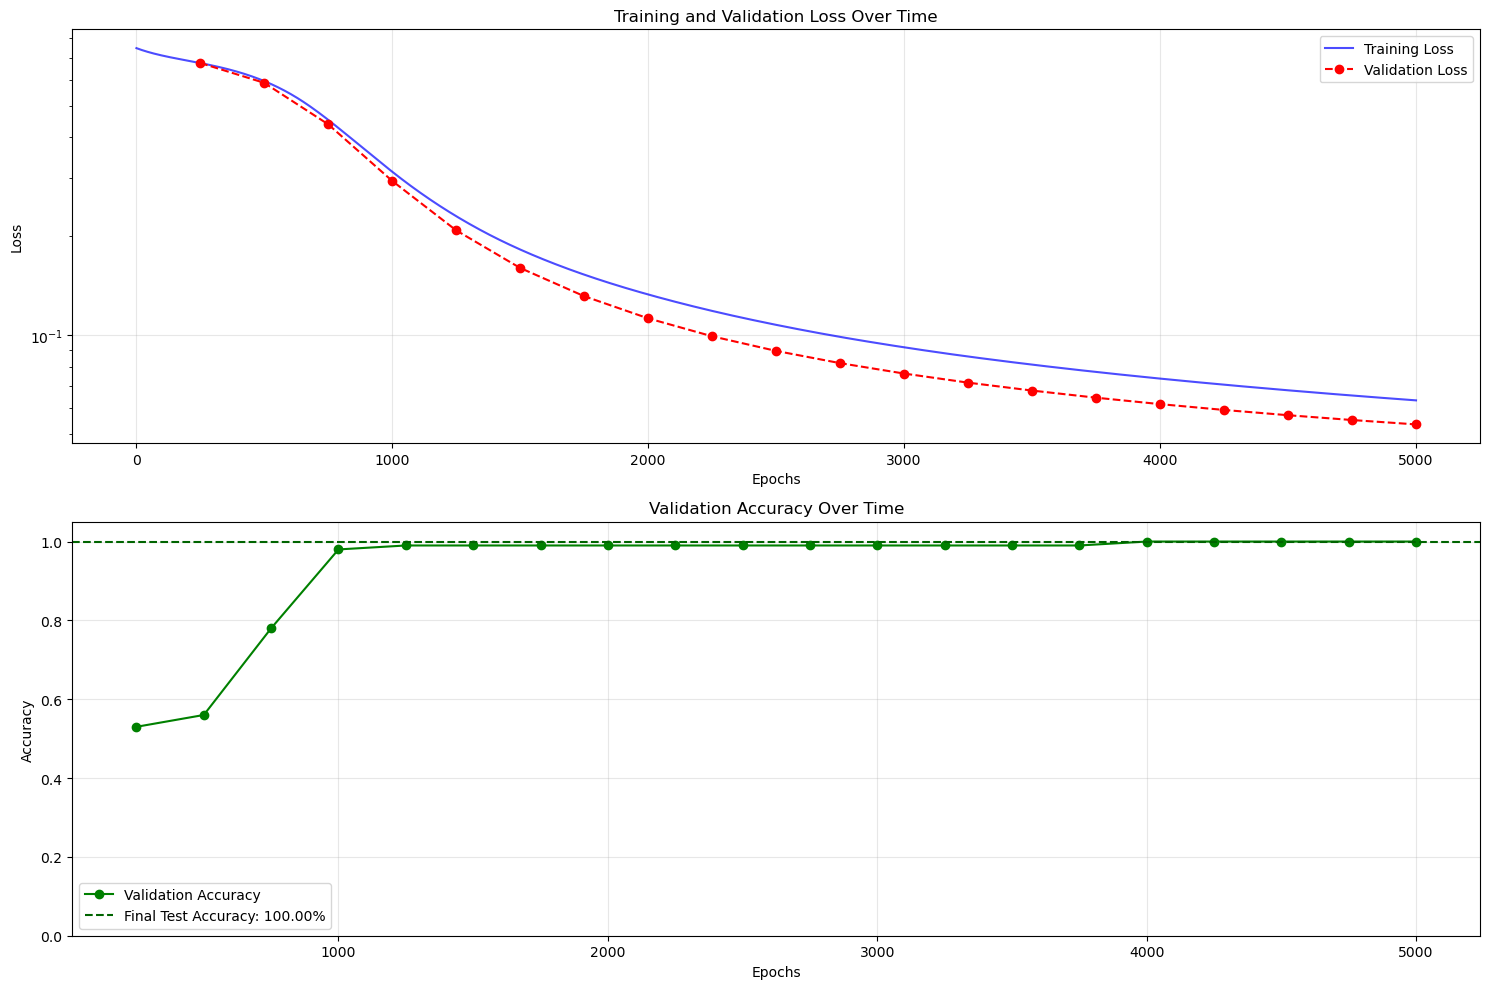

In [39]:

# Calculate final model performance
model.eval()
with torch.no_grad():
    final_train_outputs = model(X_train_tensor)
    final_train_predicted = (final_train_outputs > 0.5).float()
    final_train_accuracy = (final_train_predicted == y_train_tensor).float().mean().item()
    
    final_test_outputs = model(X_test_tensor)
    final_test_predicted = (final_test_outputs > 0.5).float()
    final_test_accuracy = (final_test_predicted == y_test_tensor).float().mean().item()

print(f"\nTraining completed in {time.time() - start_time:.2f} seconds")
print(f"Final Training Accuracy: {final_train_accuracy*100:.2f}%")
print(f"Final Testing Accuracy: {final_test_accuracy*100:.2f}%")

# Visualization of training progress
plt.figure(figsize=(15, 10))

# Loss subplot
plt.subplot(2, 1, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', color='blue', alpha=0.7)
# Plot validation loss at validation intervals
val_epochs = range(validation_interval, num_epochs+1, validation_interval)
plt.plot(val_epochs, val_losses, label='Validation Loss', color='red', linestyle='--', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale often makes loss curves more informative

# Accuracy subplot
plt.subplot(2, 1, 2)
plt.plot(val_epochs, val_accuracies, label='Validation Accuracy', color='green', marker='o')
plt.axhline(y=final_test_accuracy, color='darkgreen', linestyle='--', 
           label=f'Final Test Accuracy: {final_test_accuracy*100:.2f}%')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim([0, 1.05])  # Set y-axis from 0 to slightly above 1

plt.tight_layout()
plt.show()

In [25]:
def plot_decision_boundary(X, y, model, device, title=None):
    """
    Plot the decision boundary and predictions of a PyTorch model with clear visualization
    of correct and incorrect predictions.
    
    Args:
        X (numpy.ndarray): Input features of shape (n_samples, 2)
        y (numpy.ndarray): True labels of shape (n_samples,)
        model (torch.nn.Module): Trained PyTorch model
        device (torch.device): Device to run predictions on
        title (str, optional): Custom title for the plot
        
    Returns:
        numpy.ndarray: Predicted labels
    """
    with torch.no_grad():
        # Set model to evaluation mode
        model.eval()
        
        # Validate input shapes
        if X.shape[1] != 2:
            raise ValueError(f"Expected 2D features, got shape {X.shape}")
        if len(y) != X.shape[0]:
            raise ValueError(f"Mismatch between X shape {X.shape} and y shape {y.shape}")
            
        # Get predictions on input data
        X_tensor = torch.FloatTensor(X).to(device)
        outputs = model(X_tensor)
        predicted_probs = torch.sigmoid(outputs).cpu().numpy()
        predicted = (predicted_probs > 0.5).astype(float).squeeze()
        
        # Print diagnostic information
        print(f"Shape of X: {X.shape}")
        print(f"Shape of y: {y.shape}")
        print(f"Unique values in y: {np.unique(y)}")
        print(f"Accuracy: {100 * np.mean(predicted == y):.2f}%")
        
        # Create mesh grid for decision boundary visualization
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        
        # Use appropriate mesh density based on data range
        grid_density = min(0.02, (x_max - x_min) / 200)
        xx, yy = np.meshgrid(
            np.arange(x_min, x_max, grid_density),
            np.arange(y_min, y_max, grid_density)
        )
        
        # Get predictions for mesh grid points
        grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)
        Z = torch.sigmoid(model(grid_tensor)).cpu().numpy()
        Z = Z.reshape(xx.shape)
        
        # Create masks for correct and incorrect predictions
        correct_mask = predicted == y
        incorrect_mask = ~correct_mask
        
        # Print detailed classification metrics
        print(f"Correct predictions: {correct_mask.sum()}/{len(y)} ({100*correct_mask.sum()/len(y):.1f}%)")
        print(f"Class 0: {(y==0).sum()} samples, {correct_mask[y==0].sum()} correct")
        print(f"Class 1: {(y==1).sum()} samples, {correct_mask[y==1].sum()} correct")
        
        # Create masks for each category of prediction
        mask_0_correct = correct_mask & (y == 0)  # True negatives
        mask_0_incorrect = incorrect_mask & (y == 0)  # False positives
        mask_1_correct = correct_mask & (y == 1)  # True positives
        mask_1_incorrect = incorrect_mask & (y == 1)  # False negatives
        
        # Calculate confidence intervals for decision boundary
        confidence_levels = [0.25, 0.5, 0.75]
        
        # Create the plot with appropriate figure size
        plt.figure(figsize=(12, 10))
        
        # Plot the decision boundary with gradient fill
        decision_map = plt.contourf(xx, yy, Z, levels=100, 
                                   cmap=plt.cm.RdBu, alpha=0.3, vmin=0, vmax=1)
        
        # Add contour lines for confidence levels
        contours = plt.contour(xx, yy, Z, levels=confidence_levels,
                             colors=['gray', 'black', 'gray'], 
                             linestyles=['dotted', 'solid', 'dotted'],
                             linewidths=[1, 2, 1])
        plt.clabel(contours, inline=True, fontsize=10, fmt='%.2f')
        
        # Plot the data points with distinct markers and sizes
        s_correct, s_incorrect = 80, 160  # Marker sizes
        
        # Class 0 points - red 
        plt.scatter(X[mask_0_correct, 0], X[mask_0_correct, 1],
                   color='#D32F2F', marker='o', s=s_correct, edgecolor='black',
                   label='Correct Class 0', alpha=0.7)
        plt.scatter(X[mask_0_incorrect, 0], X[mask_0_incorrect, 1],
                   color='#D32F2F', marker='X', s=s_incorrect, edgecolor='black',
                   label='Incorrect Class 0 (FP)', alpha=0.9)
        
        # Class 1 points - blue
        plt.scatter(X[mask_1_correct, 0], X[mask_1_correct, 1],
                   color='#1565C0', marker='o', s=s_correct, edgecolor='black',
                   label='Correct Class 1', alpha=0.7)
        plt.scatter(X[mask_1_incorrect, 0], X[mask_1_incorrect, 1],
                   color='#1565C0', marker='X', s=s_incorrect, edgecolor='black',
                   label='Incorrect Class 1 (FN)', alpha=0.9)
        
        # Add true decision boundary if this is the synthetic dataset
        if np.allclose(y, (X[:,0] + X[:,1] > 0).astype(float), rtol=0, atol=1e-5):
            plt.axline([0, 0], [1, -1], color='green', linestyle='-.',
                     linewidth=2, label='True Boundary (y = -x)')
        
        # Add colorbar to interpret probability shading
        cbar = plt.colorbar(decision_map, ticks=[0, 0.25, 0.5, 0.75, 1])
        cbar.set_label('Predicted Probability (Class 1)', rotation=270, labelpad=20)
        
        # Improve plot labels and appearance
        plt.xlabel('Feature 1', fontsize=14)
        plt.ylabel('Feature 2', fontsize=14)
        
        # Set title
        if title is None:
            title = 'Neural Network Decision Boundary'
        accuracy = 100 * correct_mask.sum() / len(y)
        plt.title(f"{title}\nAccuracy: {accuracy:.2f}%", fontsize=16, pad=20)
        
        # Place legend outside to avoid covering data
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
        
        # Add grid and ensure all points are visible
        plt.grid(True, alpha=0.2)
        plt.tight_layout()
        
        # Show the plot
        plt.show()
        
        return predicted

Shape of X: (100, 2)
Shape of y: (100,)
Unique values in y: [0. 1.]
Accuracy: 100.00%
Correct predictions: 100/100 (100.0%)
Class 0: 53 samples, 53 correct
Class 1: 47 samples, 47 correct


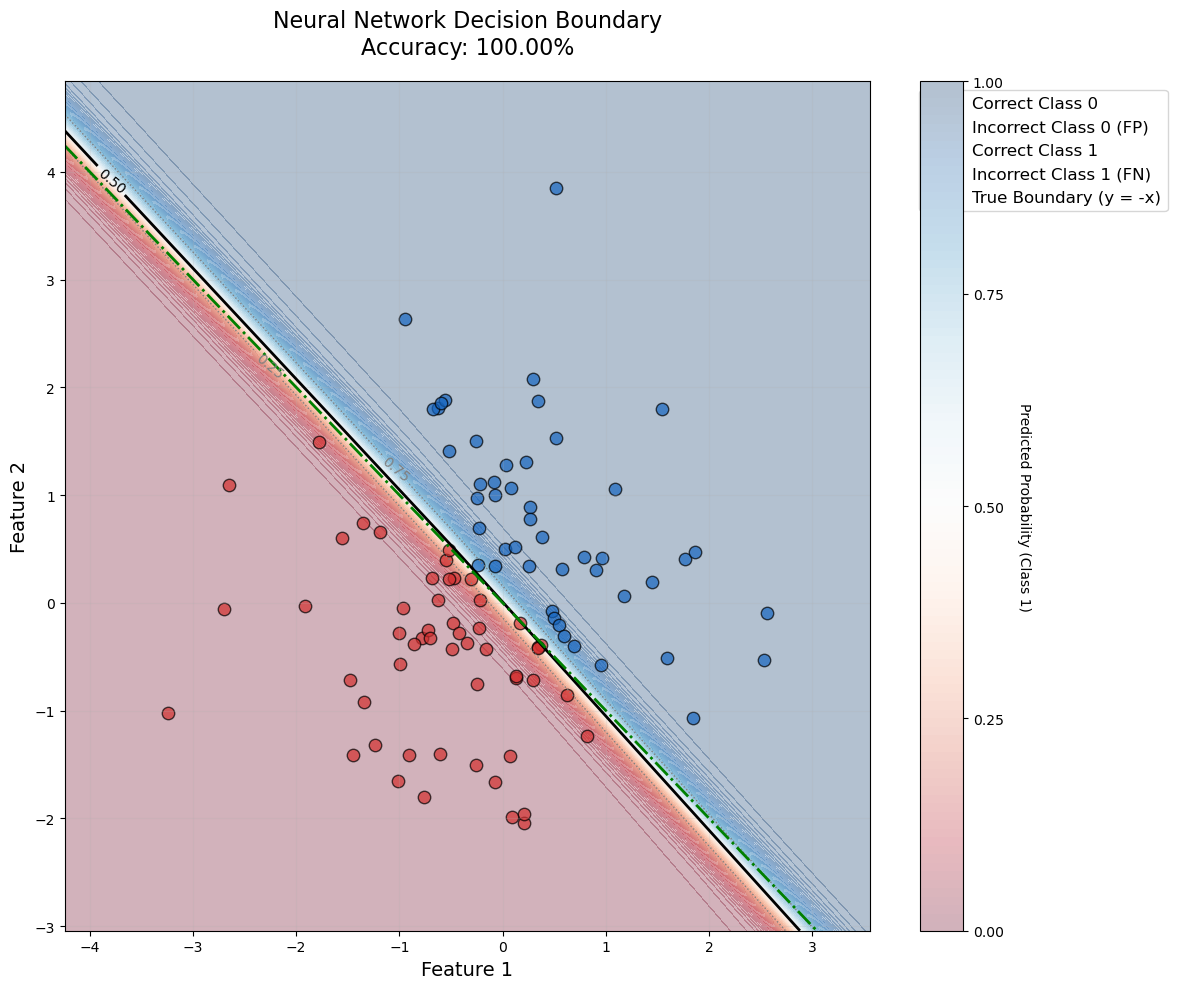

In [40]:
predicted = plot_decision_boundary(X_test, y_test, model, device)


In [27]:
def plot_confusion_matrix_and_metrics(y_true, y_pred):
    """
    Plot confusion matrix and calculate comprehensive performance metrics for binary classification.
    Handles both torch tensors and numpy arrays with proper conversion.
    
    Args:
        y_true: True labels (torch.Tensor or numpy.ndarray)
        y_pred: Predicted labels (torch.Tensor or numpy.ndarray)
    """
    # Convert inputs to numpy if they're torch tensors
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.detach().cpu().numpy().flatten()
    else:
        y_true = np.array(y_true).flatten()
        
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.detach().cpu().numpy().flatten()
    else:
        y_pred = np.array(y_pred).flatten()
    
    # Ensure binary classification (0 and 1 only)
    if not np.all(np.isin(y_true, [0, 1])) or not np.all(np.isin(y_pred, [0, 1])):
        raise ValueError("Labels must be binary (0 or 1)")
    
    # Calculate confusion matrix elements
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tp = np.sum((y_true == 1) & (y_pred == 1))
    
    # Create confusion matrix
    conf_matrix = np.array([[tn, fp], [fn, tp]])
    
    # Calculate performance metrics
    total = len(y_true)
    accuracy = (tp + tn) / total
    
    # Handle division by zero
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Calculate additional metrics
    balanced_accuracy = (recall + specificity) / 2
    ppv = precision  # Positive Predictive Value = Precision
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    
    # For highly imbalanced datasets
    prevalence = np.mean(y_true)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # First subplot: Confusion Matrix Heatmap
    im = ax1.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
    ax1.set_title('Confusion Matrix', fontsize=16, pad=20)
    
    # Add values and labels to confusion matrix
    cell_labels = [f'{conf_matrix[i, j]}\n({conf_matrix[i, j]/total:.1%})' for i in range(2) for j in range(2)]
    category_labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    
    for i in range(2):
        for j in range(2):
            color = 'white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black'
            ax1.text(j, i, f'{conf_matrix[i, j]}\n({conf_matrix[i, j]/total:.1%})\n{category_labels[i*2+j]}',
                    ha='center', va='center', color=color, fontsize=12)
    
    # Set tick marks and labels
    ax1.set_xticks([0, 1])
    ax1.set_xticklabels(['Predicted Negative', 'Predicted Positive'])
    ax1.set_yticks([0, 1])
    ax1.set_yticklabels(['Actual Negative', 'Actual Positive'])
    
    # Rotate the x tick labels for better readability
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add colorbar
    cbar = fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    cbar.set_label('Count', rotation=270, labelpad=20)
    
    # Second subplot: Metrics Visualization
    ax2.axis('off')  # Turn off axes for the metrics display
    
    # Organize metrics in a structured way
    metrics_text = (
        f"MODEL PERFORMANCE METRICS\n"
        f"═════════════════════════\n\n"
        f"• Basic Metrics:\n"
        f"  Accuracy: {accuracy:.2%}\n"
        f"  Balanced Accuracy: {balanced_accuracy:.2%}\n"
        f"  F1 Score: {f1:.2%}\n\n"
        f"• Class Predictions:\n"
        f"  Precision (PPV): {precision:.2%}\n"
        f"  Recall (Sensitivity): {recall:.2%}\n"
        f"  Specificity: {specificity:.2%}\n"
        f"  Negative Predictive Value: {npv:.2%}\n\n"
        f"• Dataset Information:\n"
        f"  Total Samples: {total}\n"
        f"  Class 1 Prevalence: {prevalence:.2%}\n"
        f"  Class Ratio: 1:{(1-prevalence)/prevalence:.1f}\n\n"
        f"• Raw Counts:\n"
        f"  True Positives: {tp}\n"
        f"  True Negatives: {tn}\n"
        f"  False Positives: {fp}\n"
        f"  False Negatives: {fn}"
    )
    
    # Display the metrics with a nice background
    props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='#4682B4', linewidth=2)
    ax2.text(0.5, 0.5, metrics_text, fontsize=12, 
             va='center', ha='center', bbox=props, family='monospace')
    
    # Add overall title
    percentage_correct = accuracy * 100
    plt.suptitle(f'Binary Classification Results\nAccuracy: {percentage_correct:.2f}%', 
                fontsize=18, y=0.98)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()
    
    # Return metrics dictionary for further use
    metrics = {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1': f1,
        'npv': npv,
        'confusion_matrix': conf_matrix
    }
    
    return metrics

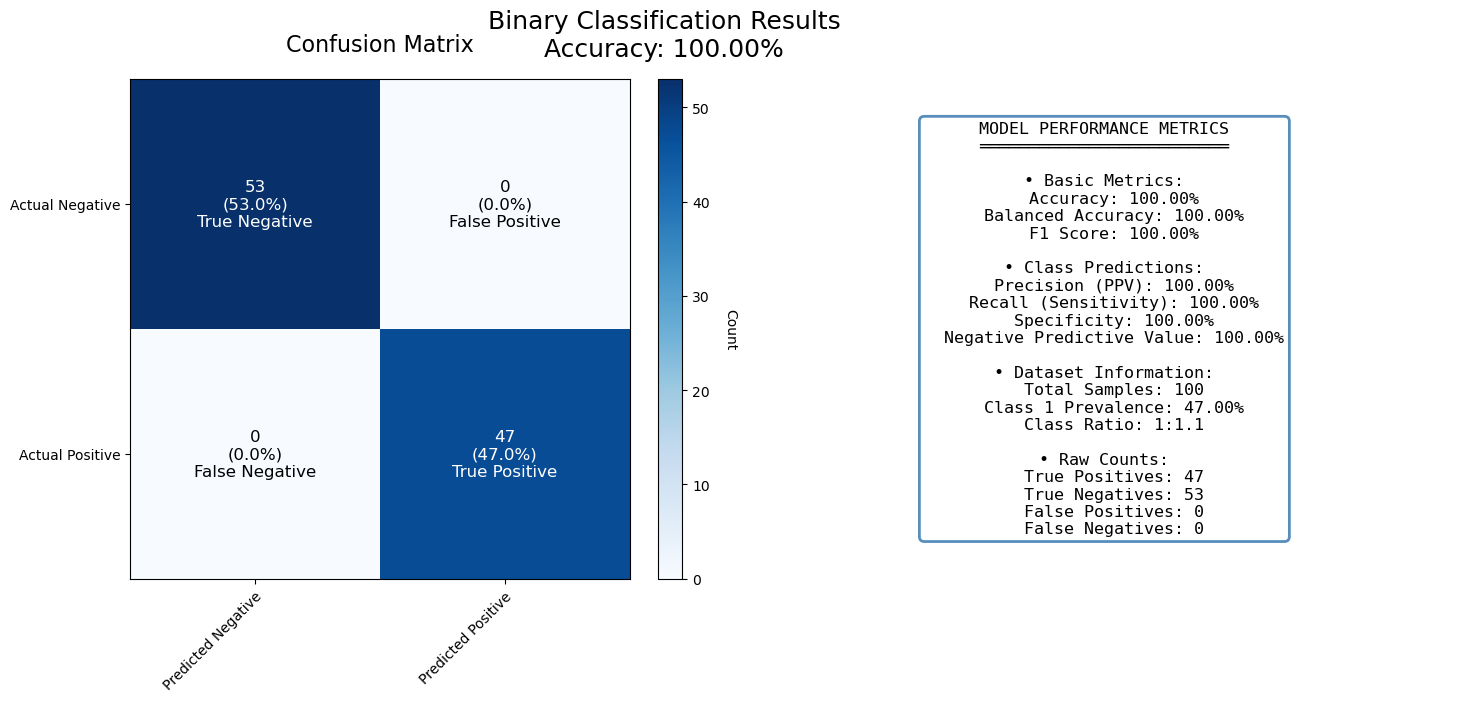

In [41]:
with torch.no_grad():
    model.eval()
    # Use X_test_tensor to get predictions specifically for the test set
    test_outputs = model(X_test_tensor)
    test_predictions = (test_outputs > 0.5).float()
    
    # Now both are the same length (200 samples)
    metrics = plot_confusion_matrix_and_metrics(y_test_tensor, test_predictions)